# Introduction to Mechanistic Interpretability

**Welcome to neuros-mechint!** This notebook introduces you to the world of mechanistic interpretability—understanding not just *what* neural networks compute, but *how* they compute it.

## What You'll Learn

By the end of this notebook, you'll understand:
- What mechanistic interpretability is and why it matters
- The core concepts: features, circuits, and interventions
- How to run your first interpretability analysis
- An overview of all major techniques in the library

## Prerequisites

- Basic Python programming
- Familiarity with PyTorch
- Understanding of neural networks (MLPs, transformers)

## Setup

First, let's make sure everything is installed correctly:

In [1]:
# Install the library if needed
# !pip install neuros-mechint[viz]

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available (optional)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Import neuros-mechint
import neuros_mechint
print(f"neuros-mechint version: {neuros_mechint.__version__}")

Using device: cuda
neuros-mechint version: 0.1.0
neuros-mechint version: 0.1.0


## Part 1: What is Mechanistic Interpretability?

### The Black Box Problem

Neural networks are powerful, but we often don't understand *how* they work internally:

```
Input → [??? Black Box ???] → Output
```

**Traditional interpretability** asks: "What features does the model use?"

**Mechanistic interpretability** asks: "How does the model transform inputs into outputs? What algorithms are implemented in the weights?"

### The Goal: Reading the "Source Code"

Imagine if we could understand neural networks like this:

```python
def neural_network(input):
    # Layer 1: Detect edges and textures
    edges = detect_edges(input)
    textures = detect_textures(input)
    
    # Layer 2: Combine into object parts
    parts = combine_features(edges, textures)
    
    # Layer 3: Recognize complete objects
    objects = recognize_objects(parts)
    
    return classify(objects)
```

This is the dream of mechanistic interpretability!

### Why This Matters

**For Neuroscience:**
- Compare how artificial and biological networks solve the same problems
- Test hypotheses about brain computation
- Discover new computational principles

**For AI Safety:**
- Detect deceptive or dangerous behaviors
- Verify alignment with human values
- Understand failure modes

**For Science:**
- Understand emergent phenomena (e.g., in-context learning)
- Discover universal computational motifs
- Bridge levels of analysis (algorithms ↔ implementation)

### Three Core Concepts

1. **Features**: Interpretable units of representation
   - Problem: Neurons are *polysemantic* (respond to many unrelated things)
   - Solution: Sparse autoencoders to find *monosemantic* features

2. **Circuits**: Connected groups of features that implement algorithms
   - Like subroutines in code
   - Example: An "induction head" circuit that completes patterns

3. **Interventions**: Causally testing what components do
   - *Activation patching*: Restore clean activations in corrupted inputs
   - *Ablation*: Remove components to see what breaks
   - *Steering*: Modify activations to change behavior

## Part 2: Your First Analysis - Understanding a Simple Transformer

Let's analyze a tiny transformer to see mechanistic interpretability in action.

### The Model: A Toy Transformer Layer

We'll use a simple transformer encoder layer—small enough to run on a laptop, but complex enough to be interesting:

In [2]:
# Create a simple transformer layer
d_model = 64      # Hidden dimension (small for laptop-friendly)
nhead = 4         # Number of attention heads
batch_size = 8
seq_len = 12

model = nn.TransformerEncoderLayer(
    d_model=d_model,
    nhead=nhead,
    dim_feedforward=256,
    dropout=0.1
).to(device)

# Create some example input
x = torch.randn(seq_len, batch_size, d_model).to(device)

# Forward pass
output = model(x)

print(f"Model input shape: {x.shape}")
print(f"Model output shape: {output.shape}")
print(f"\nModel has {sum(p.numel() for p in model.parameters()):,} parameters")

Model input shape: torch.Size([12, 8, 64])
Model output shape: torch.Size([12, 8, 64])

Model has 49,984 parameters


### Question: What Does This Transformer Actually Compute?

Looking at the weights tells us almost nothing. Let's use mechanistic interpretability to find out!

## Analysis 1: Finding Features with Sparse Autoencoders

### The Problem: Polysemanticity

Individual neurons often respond to many unrelated concepts. For example, a neuron might activate for:
- The word "apple" (fruit)
- The word "Apple" (company) 
- Red colors
- Round shapes

This makes neurons hard to interpret!

### The Solution: Sparse Autoencoders (SAEs)

SAEs learn an *overcomplete dictionary* of features:
- More features than neurons (e.g., 4× expansion)
- Each feature is *monosemantic* (represents one thing)
- Activations are *sparse* (few features active at once)

**Mathematical Setup:**

Given neuron activations $h \in \mathbb{R}^{d}$, learn:
- Encoder: $f(h) = \text{ReLU}(W_e h + b_e) \in \mathbb{R}^{m}$ where $m >> d$
- Decoder: $\hat{h} = W_d f(h)$

**Loss function:**
$$\mathcal{L} = \|h - \hat{h}\|^2 + \lambda \|f(h)\|_1$$

- First term: Reconstruction quality
- Second term: Sparsity penalty (encourages few active features)

Let's train an SAE on our transformer's activations:

Collected 4800 activation vectors of dimension 256

Training SAE...
Epoch 0/100: Loss = 0.122537
Epoch 0/100: Loss = 0.122537
Epoch 10/100: Loss = 0.003438
Epoch 10/100: Loss = 0.003438
Epoch 20/100: Loss = 0.003025
Epoch 20/100: Loss = 0.003025
Epoch 30/100: Loss = 0.003008
Epoch 30/100: Loss = 0.003008
Epoch 40/100: Loss = 0.002839
Epoch 40/100: Loss = 0.002839
Epoch 50/100: Loss = 0.002802
Epoch 50/100: Loss = 0.002802
Epoch 60/100: Loss = 0.002573
Epoch 60/100: Loss = 0.002573
Epoch 70/100: Loss = 0.002443
Epoch 70/100: Loss = 0.002443
Epoch 80/100: Loss = 0.002409
Epoch 80/100: Loss = 0.002409
Epoch 90/100: Loss = 0.002268
Epoch 90/100: Loss = 0.002268


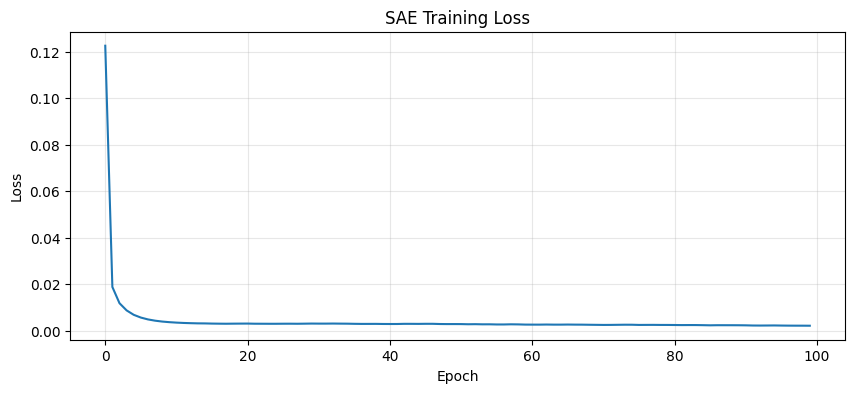


Training complete! Final loss: 0.002102


In [3]:
from neuros_mechint import SparseAutoencoder
import torch.utils.data as data

# Collect activations from the transformer's MLP layer
activations_list = []

def hook_fn(module, input, output):
    """Hook to capture intermediate activations"""
    activations_list.append(output.detach().cpu())

# Register hook on the first linear layer of the MLP
hook_handle = model.linear1.register_forward_hook(hook_fn)

# Generate more data to train the SAE
print("Collecting activations...")
for _ in range(50):  # 50 batches
    x_batch = torch.randn(seq_len, batch_size, d_model).to(device)
    with torch.no_grad():
        _ = model(x_batch)

# Remove hook
hook_handle.remove()

# Combine all activations
activations = torch.cat(activations_list, dim=1)  # (seq_len, n_samples, features)
activations = activations.reshape(-1, activations.shape[-1])  # Flatten

print(f"Collected {activations.shape[0]} activation vectors of dimension {activations.shape[1]}")

# Create SAE
sae = SparseAutoencoder(
    latent_dim=activations.shape[1],
    dictionary_size=activations.shape[1] * 4,  # 4x overcomplete
    sparsity_coefficient=0.01,  # L1 penalty strength
    tie_weights=False
)

print("\nTraining SAE...")
losses = sae.train_on_raw_activations(
    activations=activations,
    num_epochs=100,
    batch_size=128,
    learning_rate=1e-3,
    device=device
)

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SAE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nTraining complete! Final loss: {losses[-1]:.6f}")

### Analyzing the Learned Features

Now let's see what features the SAE discovered:

Feature activation shape: torch.Size([100, 1024])
Average sparsity: 62.18% (fraction of features active)


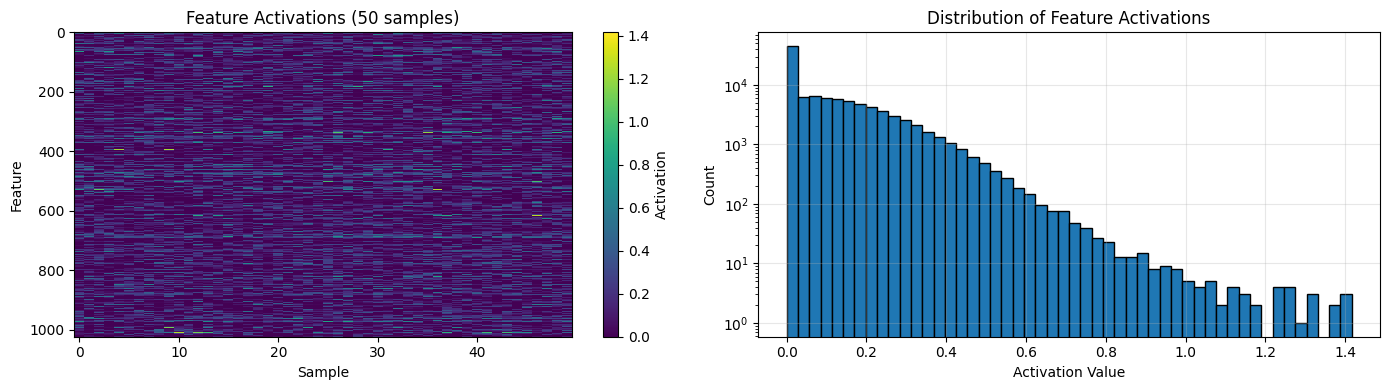


Top 10 most frequently active features:
  1. Feature 154: Active 98.0% of the time, avg activation 0.354
  2. Feature 0: Active 96.0% of the time, avg activation 0.275
  3. Feature 875: Active 96.0% of the time, avg activation 0.277
  4. Feature 933: Active 96.0% of the time, avg activation 0.291
  5. Feature 444: Active 95.0% of the time, avg activation 0.266
  6. Feature 954: Active 95.0% of the time, avg activation 0.316
  7. Feature 686: Active 95.0% of the time, avg activation 0.284
  8. Feature 523: Active 95.0% of the time, avg activation 0.267
  9. Feature 411: Active 95.0% of the time, avg activation 0.243
  10. Feature 681: Active 95.0% of the time, avg activation 0.278


In [5]:
# Get feature activations for a test batch
test_activations = activations[:100]  # Take first 100 samples

# `get_feature_activations` now returns a CPU tensor by default
feature_acts = sae.get_feature_activations(test_activations)

print(f"Feature activation shape: {feature_acts.shape}")
print(f"Average sparsity: {(feature_acts > 0).float().mean():.2%} (fraction of features active)")

# Visualize sparsity pattern (convert to numpy for matplotlib)
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Left: Activation heatmap
im = axes[0].imshow(feature_acts[:50].T.numpy(), aspect='auto', cmap='viridis', interpolation='none')
axes[0].set_xlabel('Sample')
axes[0].set_ylabel('Feature')
axes[0].set_title('Feature Activations (50 samples)')
plt.colorbar(im, ax=axes[0], label='Activation')

# Right: Activation distribution
axes[1].hist(feature_acts.numpy().flatten(), bins=50, edgecolor='black')
axes[1].set_xlabel('Activation Value')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Feature Activations')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find most active features
feature_frequency = (feature_acts > 0).float().mean(dim=0)
# argsort descending
top_features = torch.argsort(feature_frequency, descending=True)[:10]

print("\nTop 10 most frequently active features:")
for i, feat_idx in enumerate(top_features):
    freq = feature_frequency[feat_idx].item()
    nonzero = feature_acts[:, feat_idx][feature_acts[:, feat_idx] > 0]
    if nonzero.numel() > 0:
        avg_activation = nonzero.mean().item()
    else:
        avg_activation = 0.0
    print(f"  {i+1}. Feature {int(feat_idx)}: Active {freq:.1%} of the time, avg activation {avg_activation:.3f}")

### Key Insight

Notice how the SAE achieves **sparse** activations—only a small fraction of features are active for any given input. This is exactly what we want! Each feature can now represent a specific concept rather than responding to many unrelated things.

In the next notebooks, we'll learn how to:
- Interpret what each feature represents
- Build hierarchical concept dictionaries
- Use features for causal interventions

## Analysis 2: Causal Circuit Discovery

### The Question: Which Components are Causally Important?

Just because a component activates doesn't mean it's *causing* the output. We need **causal interventions**.

### Activation Patching: The Core Technique

**Setup:**
1. **Clean run**: Normal input → normal output ✓
2. **Corrupted run**: Corrupted input → wrong output ✗
3. **Patched run**: Corrupted input, but restore ("patch") clean activations at a specific layer

**If patching fixes the output**, that component is causally important!

**Recovery score**: $R = \frac{\text{loss(corrupted)} - \text{loss(patched)}}{\text{loss(corrupted)} - \text{loss(clean)}}$
- $R \approx 1$: Component is critical
- $R \approx 0$: Component doesn't matter

Let's try this:

In [9]:
from neuros_mechint.interventions import ActivationPatcher
from neuros_mechint.interventions.patching import PatchSpec
import difflib

# Create clean and corrupted inputs
clean_input = torch.randn(seq_len, 1, d_model).to(device)
corrupted_input = torch.randn(seq_len, 1, d_model).to(device)  # Different random input

# Define a simple loss (e.g., distance from clean output). Return a float.
with torch.no_grad():
    clean_output = model(clean_input)

def compute_loss(output):
    """Loss: distance from clean output (returns float)"""
    return torch.nn.functional.mse_loss(output, clean_output).item()

# Test different components (these should match module names in the model)
components_to_test = [
    'self_attn',  # Attention sublayer
    'linear1',    # First MLP layer
    'linear2',    # Second MLP layer
]

# --- Validation: ensure the requested component names exist in the model ---
module_names = [name for name, _ in model.named_modules()]
missing = [c for c in components_to_test if c not in module_names]
if missing:
    print("Warning: the following component names were not found in model.named_modules():")
    for m in missing:
        close = difflib.get_close_matches(m, module_names, n=3)
        if close:
            print(f"  - '{m}' not found. Did you mean: {close}?")
        else:
            print(f"  - '{m}' not found.")

# Keep only valid component names
components_to_test = [c for c in components_to_test if c in module_names]
if not components_to_test:
    print("No valid component names found — skipping patching run.")
else:
    results = {}

    print("Testing causal importance of components...\n")

    # Instantiate the patcher (it will move the model to the chosen device)
    patcher = ActivationPatcher(model=model)

    for comp_name in components_to_test:
        # Build a PatchSpec for this component/layer
        patch = PatchSpec(layer_name=comp_name, component='all', source='clean')

        # Run patching experiment with a list containing this single patch
        result = patcher.patch(
            clean_input=clean_input,
            corrupted_input=corrupted_input,
            patches=[patch],
            metric_fn=compute_loss,
        )

        results[comp_name] = result

        print(f"{comp_name}:")
        print(f"  Clean metric: {result['clean_metric']:.4f}")
        print(f"  Corrupted metric: {result['corrupted_metric']:.4f}")
        print(f"  Patched metric: {result['patched_metric']:.4f}")
        print(f"  Recovery score: {result['recovery_score']:.2%}")
        print()

Testing causal importance of components...

self_attn:
  Clean metric: 0.0000
  Corrupted metric: 1.8953
  Patched metric: 1.8953
  Recovery score: -0.00%

linear1:
  Clean metric: 0.0000
  Corrupted metric: 1.8953
  Patched metric: 1.8953
  Recovery score: -0.00%

linear2:
  Clean metric: 0.0000
  Corrupted metric: 1.8953
  Patched metric: 1.8953
  Recovery score: -0.00%



### Visualizing Component Importance

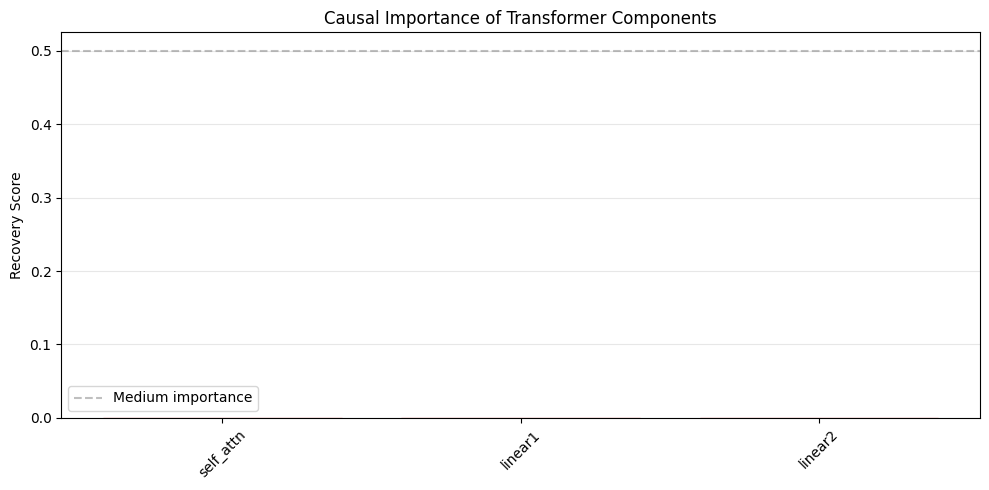


Interpretation:
Green: Highly important (recovery > 70%)
Orange: Moderately important (30-70%)
Red: Less important (< 30%)


In [10]:
# Extract recovery scores
component_names = list(results.keys())
recovery_scores = [results[name]['recovery_score'] for name in component_names]

# Create bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(component_names)), recovery_scores, edgecolor='black')

# Color bars by importance
for i, bar in enumerate(bars):
    score = recovery_scores[i]
    if score > 0.7:
        bar.set_color('darkgreen')
    elif score > 0.3:
        bar.set_color('orange')
    else:
        bar.set_color('lightcoral')

plt.xticks(range(len(component_names)), component_names, rotation=45)
plt.ylabel('Recovery Score')
plt.title('Causal Importance of Transformer Components')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Medium importance')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("Green: Highly important (recovery > 70%)")
print("Orange: Moderately important (30-70%)")
print("Red: Less important (< 30%)")

### Key Insights

This simple experiment reveals which components are **causally necessary** for the computation:
- High recovery score → Component is critical for this task
- Low recovery score → Component has minimal causal impact

This is more informative than just looking at activation magnitudes!

In Notebook 03, we'll learn to:
- Trace information flow through entire circuits
- Build causal graphs
- Discover minimal sufficient subnetworks

## Part 3: Overview of All Techniques in the Library

You've now seen two core techniques: **Sparse Autoencoders** for finding features and **Activation Patching** for discovering circuits. But there's so much more!

### The Complete Toolkit

#### 1. Feature Discovery & Analysis
- **Sparse Autoencoders** (SAEs): Decompose polysemantic neurons
- **Hierarchical SAEs**: Multi-level concept hierarchies
- **Feature Attribution**: Integrated Gradients, DeepLIFT, SHAP
- **Concept Dictionaries**: Semantic labeling of features

#### 2. Causal Interventions
- **Activation Patching**: Test component importance
- **Ablation Studies**: Systematic component removal
- **Path Analysis**: Trace information flow
- **Counterfactuals**: What-if analysis

#### 3. Circuit Extraction
- **Latent RNN Models**: Minimal explanatory circuits
- **DUNL**: Demixed sparse coding for mixed selectivity
- **Feature Visualization**: What do neurons/features respond to?
- **Motif Detection**: Find recurring computational patterns

#### 4. Biological Realism
- **Fractal Analysis**: Measure scale-free dynamics
- **Fractal Regularization**: Enforce biological complexity
- **Spiking Neural Networks**: LIF, Izhikevich, Hodgkin-Huxley
- **Dale's Law**: Excitatory/inhibitory separation
- **Synaptic Plasticity**: STDP, short-term dynamics

#### 5. Brain Alignment
- **CCA**: Canonical Correlation Analysis for alignment
- **RSA**: Representational Similarity Analysis
- **PLS**: Partial Least Squares for prediction
- **Statistical Testing**: Noise ceilings, significance tests

#### 6. Dynamical Systems
- **Koopman Operators**: Linearize nonlinear dynamics
- **Lyapunov Exponents**: Measure chaos and stability
- **Fixed Point Analysis**: Find attractors
- **Controllability**: Plan interventions

#### 7. Information Theory
- **Mutual Information**: MINE estimator for information flow
- **Information Plane**: Track compression during training
- **Energy Landscapes**: Map basins of attraction
- **Entropy Production**: Thermodynamic analysis

#### 8. Geometry & Topology
- **Manifold Analysis**: Intrinsic dimensionality, curvature
- **Persistent Homology**: Topological data analysis
- **Geodesic Distances**: True distances on manifolds

#### 9. Meta-Dynamics
- **Training Trajectories**: How representations evolve
- **Phase Detection**: Identify critical periods
- **Feature Emergence**: Track when features appear
- **Representational Drift**: Measure stability

### The Big Picture: How These Techniques Work Together

Here's a typical workflow combining multiple techniques:

```
1. Train your model
2. Extract features (SAEs) → Understand WHAT is represented
3. Find circuits (Patching) → Understand HOW computation happens
4. Analyze dynamics (Koopman, fixed points) → Understand temporal evolution
5. Compare to brain (CCA, RSA) → Validate biological relevance
6. Generate explanations → Communicate findings
```

Each technique gives you a different lens to understand the same network!

## Part 4: A Roadmap for Your Learning Journey

### Recommended Path

**Week 1: Foundations**
- ✓ This notebook (01)
- Notebook 02: Sparse Autoencoders in depth
- Notebook 03: Causal interventions

**Week 2: Biological Connection**
- Notebook 04: Fractal analysis
- Notebook 05: Brain alignment
- Notebook 08: Biophysical modeling

**Week 3: Advanced Analysis**
- Notebook 06: Dynamical systems
- Notebook 07: Circuit extraction
- Notebook 09: Information theory

**Week 4: Expert Topics**
- Notebook 10: Advanced topics
- Your own research projects!

### Tips for Success

1. **Run the code**: Don't just read—experiment!
2. **Modify parameters**: Change hyperparameters and see what happens
3. **Use your own models**: Apply these techniques to models you care about
4. **Connect to papers**: Read the cited research papers
5. **Ask questions**: Open issues on GitHub or discuss with others

### Common Applications

**For neuroscientists:**
```python
# Compare your model to brain recordings
from neuros_mechint.alignment import CCA, RSA

# Align representations
cca = CCA(n_components=20)
cca.fit(model_activations, brain_data)
alignment_score = cca.score(model_activations_test, brain_data_test)

# Compare geometries
rsa = RSA(metric='correlation')
similarity = rsa.compare(model_activations, brain_data)
```

**For AI researchers:**
```python
# Understand a transformer
from neuros_mechint import SparseAutoencoder
from neuros_mechint.interventions import ActivationPatcher

# Extract features
sae = SparseAutoencoder(input_dim=768, hidden_dim=3072)
sae.train_on_activations(activations)

# Find circuits
patcher = ActivationPatcher(model, layer_name='attention')
results = patcher.run_full_analysis(clean_input, corrupted_input)
```

**For ML engineers:**
```python
# Enforce biological realism during training
from neuros_mechint.fractals import SpectralPrior, HiguchiFractalDimension

# Add fractal regularization
fractal_loss = SpectralPrior(target_exponent=1.0, weight=0.1)
total_loss = task_loss + fractal_loss(hidden_states)

# Monitor complexity
fd_metric = HiguchiFractalDimension(kmax=10)
complexity = fd_metric(neural_timeseries)
```

## Part 5: Practice Exercise

Now it's your turn! Try modifying the code above to:

### Exercise 1: Explore Different SAE Configurations
1. Train SAEs with different sparsity coefficients (0.001, 0.01, 0.1)
2. Try different expansion factors (2x, 4x, 8x)
3. Compare the sparsity and reconstruction quality

### Exercise 2: Test Different Interventions
1. Create a more structured "corruption" (e.g., add noise only to specific positions)
2. Test patching at individual attention heads
3. Visualize how recovery score changes across layers

### Exercise 3: Combine Techniques
1. Train an SAE on activations
2. Use the learned features for activation patching
3. Identify which features are causally important

Here's a starter template:

In [ ]:
# Exercise workspace: full experiments
# 1) Train SAEs with different sparsity coefficients and expansion factors
# 2) Test patching with structured corruptions
# 3) Combine SAE features with causal patching on top-activating sequences

import time
from neuros_mechint import SparseAutoencoder
from neuros_mechint.interventions import ActivationPatcher
from neuros_mechint.interventions.patching import PatchSpec

torch.manual_seed(0)
np.random.seed(0)

# Parameters for quick experiments (reduce sizes for notebook responsiveness)
sparsity_values = [0.001, 0.01, 0.1]
expansion_factors = [2, 4]
num_epochs = 30
train_batch_size = 128

# Use the cached activations we already collected earlier in the notebook if present,
# otherwise collect a small set here. We expect `activations` variable to exist from above.
try:
    activations  # noqa: F821
    print("Using existing `activations` tensor from notebook scope.")
except NameError:
    # Collect a small set of activations (same hook pattern used earlier)
    print("No cached `activations` found - collecting a small set for exercises...")
    activations_list = []

    def hook_fn_local(module, input, output):
        activations_list.append(output.detach().cpu())

    h = model.linear1.register_forward_hook(hook_fn_local)

    n_collect_batches = 8
    eval_batch_size = 8
    for _ in range(n_collect_batches):
        xb = torch.randn(seq_len, eval_batch_size, d_model).to(device)
        with torch.no_grad():
            _ = model(xb)
    h.remove()

    activations = torch.cat(activations_list, dim=1)  # (seq_len, total_samples, features)
    activations = activations.reshape(-1, activations.shape[-1])  # (N, features)

print(f"Activations shape for experiments: {activations.shape}")

# Split into train/test
N = activations.shape[0]
perm = torch.randperm(N)
train_idx = perm[: int(0.8 * N)]
test_idx = perm[int(0.8 * N):]
train_acts = activations[train_idx]
test_acts = activations[test_idx]

experiment_results = []

for sparsity in sparsity_values:
    for factor in expansion_factors:
        dict_size = int(activations.shape[1] * factor)
        print(f"\nTraining SAE (sparsity={sparsity}, expansion={factor}x -> dict={dict_size})")
        sae = SparseAutoencoder(
            latent_dim=activations.shape[1],
            dictionary_size=dict_size,
            sparsity_coefficient=sparsity,
            tie_weights=False,
        )

        t0 = time.time()
        losses = sae.train_on_raw_activations(
            activations=train_acts,
            num_epochs=num_epochs,
            batch_size=train_batch_size,
            learning_rate=1e-3,
            device=device,
        )
        t1 = time.time()

        # Evaluate on test set: reconstruction MSE and average sparsity
        with torch.no_grad():
            # features returned on CPU by design
            recon, feats, loss = sae(test_acts.to(device), return_features=True)
            # recon is on device; move to cpu for metrics
            recon_cpu = recon.cpu()
            recon_mse = torch.nn.functional.mse_loss(recon_cpu, test_acts).item()
            avg_sparsity = (feats == 0).float().mean().item()

        print(f"Done ({t1 - t0:.1f}s). Final epoch loss: {losses[-1]:.6f}; test MSE: {recon_mse:.6f}; avg sparsity: {avg_sparsity:.3f}")

        experiment_results.append({
            'sparsity': sparsity,
            'expansion': factor,
            'dict_size': dict_size,
            'losses': losses,
            'test_mse': recon_mse,
            'avg_sparsity': avg_sparsity,
            'sae': sae,
        })

# Summarize experiments
print('\nExperiment summary:')
for r in experiment_results:
    print(f"s={r['sparsity']}, exp={r['expansion']}x, dict={r['dict_size']}: test_mse={r['test_mse']:.6f}, avg_sparsity={r['avg_sparsity']:.3f}")

# ------------------------------------------------------------------
# Part 2: Test patching with different corruptions (structured)
# We'll evaluate on a small synthetic dataset of sequences and test patching
# at a few model components.
# ------------------------------------------------------------------

# Collect a small set of inputs and corresponding activations (store sequences)
print('\nCollecting small evaluation dataset for patching...')
inputs_list = []
activations_list = []

def hook_fn_collect(module, input, output):
    activations_list.append(output.detach().cpu())

h2 = model.linear1.register_forward_hook(hook_fn_collect)

n_eval_batches = 8
eval_batch_size = 8
for _ in range(n_eval_batches):
    xb = torch.randn(seq_len, eval_batch_size, d_model).to(device)
    with torch.no_grad():
        _ = model(xb)
    inputs_list.append(xb.cpu())

h2.remove()

# inputs_cat: (seq_len, total_samples, d_model)
inputs_cat = torch.cat(inputs_list, dim=1)
acts_cat = torch.cat(activations_list, dim=1)  # (seq_len, total_samples, features)

print(f"Collected sequences: inputs {inputs_cat.shape}, activations {acts_cat.shape}")

# We'll test patches on these sequences
patcher = ActivationPatcher(model=model)

components_to_test = ['linear1', 'linear2']

# Structured corruptions: (A) add noise to specific token positions, (B) zero-out embeddings for positions
position_to_corrupt = 0

results_patching = {}

# Prepare clean and corrupted batches
# Use the full set as a batch for speed: shape expected is (seq_len, batch, d_model)
clean_batch = inputs_cat.to(device)

# Corruption A: add Gaussian noise to position `position_to_corrupt`
corrupted_a = clean_batch.clone()
noise_level = 2.0
corrupted_a[position_to_corrupt, :, :] += noise_level * torch.randn_like(corrupted_a[position_to_corrupt, :, :])

# Corruption B: zero-out embeddings at the chosen position
corrupted_b = clean_batch.clone()
corrupted_b[position_to_corrupt, :, :] = 0.0

for comp in components_to_test:
    patch = PatchSpec(layer_name=comp, component='all', source='clean')

    # Run for corruption A
    res_a = patcher.patch(clean_input=clean_batch, corrupted_input=corrupted_a, patches=[patch], metric_fn=lambda out: torch.nn.functional.mse_loss(out, model(clean_batch)).item())
    # Run for corruption B
    res_b = patcher.patch(clean_input=clean_batch, corrupted_input=corrupted_b, patches=[patch], metric_fn=lambda out: torch.nn.functional.mse_loss(out, model(clean_batch)).item())

    results_patching[comp] = {
        'corruption_a': res_a,
        'corruption_b': res_b,
    }

    print(f"Component {comp}: corruption A recovery={res_a['recovery_score']:.3f}, corruption B recovery={res_b['recovery_score']:.3f}")

# ------------------------------------------------------------------
# Part 3: Combine SAE features with causal analysis
# Approach:
#  - Use the last-trained SAE (from experiment_results[-1]) as an example
#  - Compute feature activations for the evaluation activations and pick a top feature
#  - Select the top-k sequence samples where that feature is most active
#  - Run patcher.patch on exactly those sequences to get a recovery score
# ------------------------------------------------------------------

print('\nCombining SAE features with patching (example using last trained SAE)...')
sae_example = experiment_results[-1]['sae']

# Compute feature activations for all collected activation vectors (acts_cat flattened)
acts_flat = acts_cat.reshape(-1, acts_cat.shape[-1])  # (N, features)
with torch.no_grad():
    feats_all = sae_example.get_feature_activations(acts_flat)  # CPU tensor (N, dict_size)

# Choose the most frequently active feature
feature_frequency = (feats_all > 0).float().mean(dim=0)
top_feat = int(torch.argmax(feature_frequency).item())
print(f"Top feature index (most frequently active): {top_feat}")

# Find top-k flattened indices where this feature is largest
k = 16
feat_vals = feats_all[:, top_feat]
_, top_indices = torch.topk(feat_vals, k=min(k, feat_vals.shape[0]))

# Map flattened indices back to (seq_pos, sample_idx)
seq_len_collected, total_samples, _ = acts_cat.shape
selected_sample_indices = []
for f_idx in top_indices.tolist():
    seq_pos = f_idx // total_samples
    sample_idx = f_idx % total_samples
    selected_sample_indices.append(sample_idx)

# Build a batch of sequences containing the selected sample indices
# Remove duplicates while preserving order
seen = set()
selected_sample_indices = [x for x in selected_sample_indices if not (x in seen or seen.add(x))]

if len(selected_sample_indices) == 0:
    print("No samples selected for combine step (unexpected).")
else:
    sel_clean = inputs_cat[:, selected_sample_indices, :].to(device)  # (seq_len, batch_sel, d_model)
    sel_corrupted = sel_clean.clone()
    # Simple corruption: add medium Gaussian noise to position 0
    sel_corrupted[0] += 1.0 * torch.randn_like(sel_corrupted[0])

    # Patch the MLP layer (linear1) and see recovery for these samples
    patch_feat = PatchSpec(layer_name='linear1', component='all', source='clean')
    res_sel = patcher.patch(clean_input=sel_clean, corrupted_input=sel_corrupted, patches=[patch_feat], metric_fn=lambda out: torch.nn.functional.mse_loss(out, model(sel_clean)).item())

    print(f"For top feature {top_feat}, patched recovery (selected samples): {res_sel['recovery_score']:.3f}")

print('\nExercise workspace completed.')


## Summary & Next Steps

### What You've Learned

1. **Mechanistic interpretability** aims to reverse-engineer the "source code" of neural networks
2. **Sparse Autoencoders** decompose neurons into interpretable, monosemantic features
3. **Activation patching** reveals which components are causally necessary
4. The library offers **10+ major technique families** for comprehensive analysis

### Key Takeaways

- Interpretability is not just about *inputs* and *outputs*—it's about understanding the *algorithm*
- Different techniques provide complementary insights (features, circuits, dynamics, etc.)
- These methods work on models of any size (from toys to GPT-scale)
- The same techniques apply to both artificial and biological neural networks

### Next Steps

**Ready to dive deeper?** Here's what to explore next:

1. **[Notebook 02: Sparse Autoencoders](02_sparse_autoencoders.ipynb)**
   - Deep dive into SAE training and interpretation
   - Hierarchical concept extraction
   - Causal SAE interventions

2. **[Notebook 03: Causal Interventions](03_causal_interventions.ipynb)**
   - Advanced patching techniques
   - Building causal graphs
   - Circuit discovery workflows

3. **[Notebook 04: Fractal Analysis](04_fractal_analysis.ipynb)**
   - Understanding biological complexity
   - Training with fractal regularization
   - Comparing model and brain dynamics

### Additional Resources

**Papers to Read:**
- Elhage et al. (2021): "A Mathematical Framework for Transformer Circuits"
- Anthropic (2023): "Towards Monosemanticity"
- Olah et al. (2020): "Zoom In: An Introduction to Circuits"
- Sussillo & Barak (2013): "Opening the Black Box"

**Websites:**
- [Anthropic's Interpretability Research](https://transformer-circuits.pub/)
- [Neuronpedia](https://neuronpedia.org/) - Browse interpretable features
- [Distill.pub](https://distill.pub/) - Visual explanations

### Get Involved!

This library is designed to become a **community standard** for mechanistic interpretability in neuroscience and AI. We welcome:
- Bug reports and feature requests
- New example notebooks
- Integrations with your research
- Documentation improvements

Together, we can make neural networks—artificial and biological—truly interpretable!

---

**Ready to continue?** Open [02_sparse_autoencoders.ipynb](02_sparse_autoencoders.ipynb) to master feature discovery!